In [1]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.6/dist-packages (0.13.0)


In [0]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
# !gsutil ls gs://{gs_path}

Run the following only once.

In [0]:
# Pull from GS
gs_path = 'platform-ai-research/datasets/ProductNet/'

# file_name = 'df_new_label'
# remote_file = gs_path + file_name
# !gsutil cp gs://{remote_file} {file_name} 


# file_name = 'images_999' # urls_20000
# remote_file = gs_path + file_name
# !gsutil -m cp -r gs://{remote_file} {file_name} 

Our final working `df` is `df_new_label`. It contains 784 entries and 10 classes. The folder we store the images is `images_784`. These can be found in the GS bucket.

Rerun from here after cleaning the labels.

In [0]:
# get the csv from platform.ai
pnet = pd.read_csv('ProductNet_small_prediction (2).csv')

# remove duplicates
pnet = pnet.drop_duplicates()

# create asin column
pnet['asin'] = pnet['file_name'].str.strip('.jpg')

# get the list of asins
pnet_asins = pnet['asin'].tolist()

# read in original urls df
urls_20000 = pd.read_feather('urls_20000')

# merge pnet with urls
final = pd.merge(pnet, urls_20000,
                 left_on='asin', right_on='asin',
                 how='inner')

In [5]:
len(pnet), len(final)

(785, 785)

In [0]:
# Pull images into new folder

imUrls = final['imUrl'].tolist()
asins = final['asin'].tolist()

for url_label_id in zip(imUrls, asins):
    url = url_label_id[0] # url of image
    asin = url_label_id[1] # asin of image
    
    filename = './images_784/' + asin + '.jpg'      
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            final = final[final.asin != asin]           # if missing, remove from dataset
            with open("./missing_from_784.txt", "a") as f:
                f.write(asin+'\n')

In [0]:
from PIL import Image

for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    
    filename = './images_784/' + asin + '.jpg'      
    
    try:
        img = Image.open(filename)
    except Exception as e:
        final = final[final.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs_784.txt", "a") as f:
            f.write(asin+'\n')

In [8]:
final.head()

,file_name,labeled_class,predicted_class,prediction_confidence,image_url,asin,imUrl
0,B006F64S7Y.jpg,jewelry,jewelry,0.999982,1,B006F64S7Y,http://ecx.images-amazon.com/images/I/417zWrvK...
1,B006OHTI1K.jpg,jewelry,jewelry,0.999824,1,B006OHTI1K,http://ecx.images-amazon.com/images/I/3190FJSu...
2,B005MQLE9S.jpg,shoes,shoes,0.972866,1,B005MQLE9S,http://ecx.images-amazon.com/images/I/419gMrUA...
3,B003UUM3IO.jpg,shoes,shoes,0.951584,1,B003UUM3IO,http://ecx.images-amazon.com/images/I/41dOCa7y...
4,B00DCADTKI.jpg,shoes,shoes,0.992756,1,B00DCADTKI,http://ecx.images-amazon.com/images/I/31%2BAHF...


In [0]:
remove = ['B00IQHQQW0', 'B005FYG8PM', 'B005K2VQ6A', 
          'B00G6SDUYS', 'B001NH19BI', 'B004Q5G9WS', 
          'B003VBU172', 'B001BNNX4K'] # []

df = final[['asin', 'labeled_class']].copy()

df = df[~df['asin'].isin(remove)]

In [10]:
print('len of df:', len(df))

len of df: 777


In [0]:
np.random.seed(42)

tfms = get_transforms() # max_lighting=0.1, max_zoom=1.05, max_warp=0.

src = ImageDataBunch.from_df('./', 
                             df, 
                             folder='images_784', 
                             suffix='.jpg', 
                             ds_tfms=tfms, 
                             size=224, 
                             bs=64).normalize(imagenet_stats)

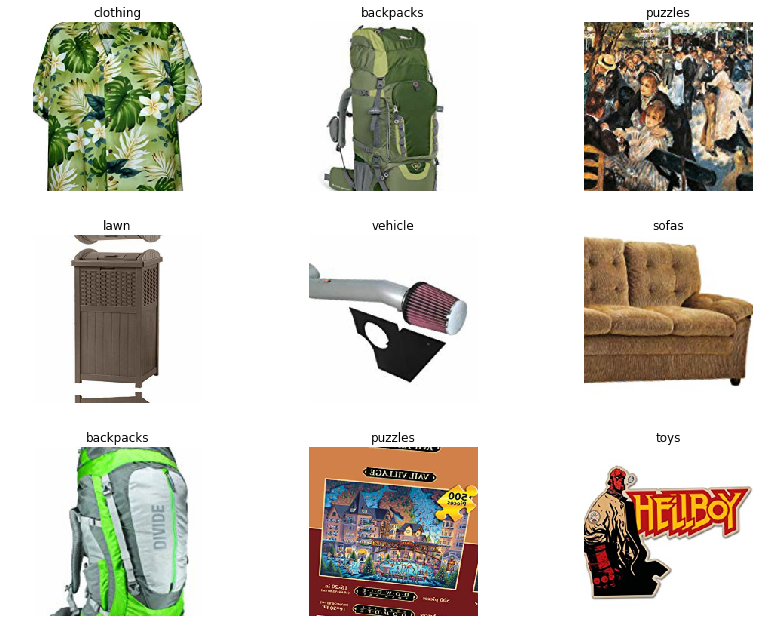

In [12]:
src.show_batch(rows=3, figsize=(12,9))

In [13]:
# # print(src.classes)
len(src.classes)

10

In [14]:
df.head()

,asin,labeled_class
0,B006F64S7Y,jewelry
1,B006OHTI1K,jewelry
2,B005MQLE9S,shoes
3,B003UUM3IO,shoes
4,B00DCADTKI,shoes


In [0]:
learn = cnn_learner(src, models.resnet50, metrics=error_rate)

In [16]:
gc.collect()

16069

In [17]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.923610,0.740413,0.232258,00:09
1,1.177969,0.390652,0.141935,00:08
2,0.818973,0.340971,0.109677,00:07
3,0.633283,0.348973,0.096774,00:07
4,0.499493,0.348087,0.096774,00:06


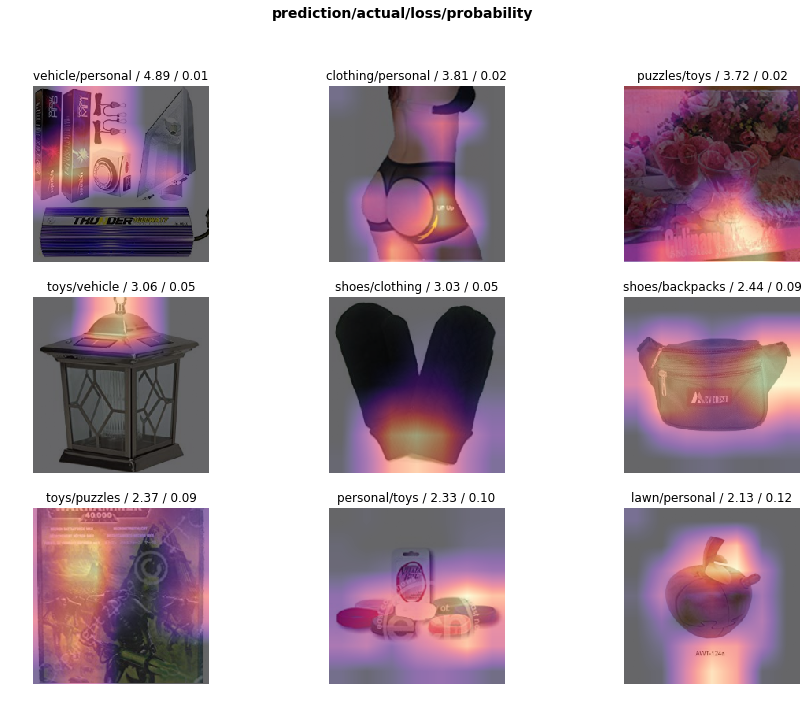

In [18]:
# interp_train = ClassificationInterpretation.from_learner(learn, 1)

interp_valid = ClassificationInterpretation.from_learner(learn)
interp_valid.plot_top_losses(9, figsize=(15,11))

Find the mislabeled `asin`.

In [0]:
# losses_train, idxs_train = interp_train.top_losses()
# losses_valid, idxs_valid = interp_valid.top_losses()

# train_bad_labels_idx = [idx for idx in idxs_train[:10]]
# valid_bad_labels_idx = [idx for idx in idxs_valid[:10]]

# train = src.train_ds.x.items[:]
# valid = src.valid_ds.x.items[:]

# train_bad_asin = []
# valid_bad_asin = []

# for idx in train_bad_labels_idx:
#     img_name_path = train[idx]
#     asin = str(img_name_path).strip('.jpg').strip('/images_784')
#     train_bad_asin.append(asin)
    
# for idx in valid_bad_labels_idx:
#     img_name_path = valid[idx]
#     asin = str(img_name_path).strip('.jpg').strip('/images_784')
#     valid_bad_asin.append(asin)
    
# bad = final[(final['asin'].isin(train_bad_asin)) |
#             (final['asin'].isin(valid_bad_asin))]

# bad    

# asins = bad['asin'].tolist()

# print(asins)

In [0]:
# # # use to check for bad labels
# remove = [4, 11, 16]

# drops = [asins[idx] for idx in remove]

# print(drops)

# # asin = asins[19]

# # filename = './images_784/' + asin + '.jpg'      

# # img = Image.open(filename)

# # img

In [0]:
learn.unfreeze()

In [22]:
gc.collect()

14913

In [23]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.227609,0.924742,0.212903,00:08
1,0.206032,0.903621,0.167742,00:07


In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


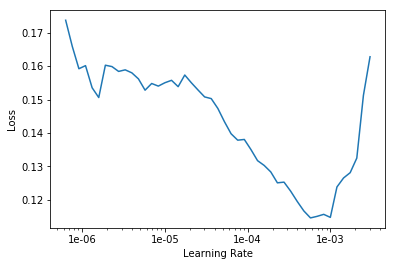

In [25]:
learn.recorder.plot()

In [0]:
learn.save('before_lr')

In [27]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.174723,0.777687,0.135484,00:08
1,0.132043,0.674350,0.122581,00:08
2,0.103980,0.613126,0.135484,00:08
3,0.090148,0.593878,0.122581,00:08


Code below is taken from the NYC cohort. Many thanks to them.

In [28]:
tta_mod = []
for i in np.arange(0.7, 1.4, 0.05):
   tta_mod.append((i, accuracy(*learn.TTA(scale=i))))

In [29]:
sorted(tta_mod, key=lambda e:e[1], reverse=True)

[(1.1500000000000004, tensor(0.8968)),
 (0.9000000000000001, tensor(0.8903)),
 (0.9500000000000002, tensor(0.8903)),
 (1.0500000000000003, tensor(0.8903)),
 (1.1000000000000003, tensor(0.8903)),
 (1.2000000000000004, tensor(0.8903)),
 (0.8500000000000001, tensor(0.8839)),
 (1.0000000000000002, tensor(0.8839)),
 (1.3500000000000005, tensor(0.8839)),
 (0.7, tensor(0.8774)),
 (0.75, tensor(0.8774)),
 (0.8, tensor(0.8774)),
 (1.2500000000000004, tensor(0.8774)),
 (1.3000000000000005, tensor(0.8774))]